# NYC Apartment Search

## Final Project - Group 1: Hanlong Cheng & Princeton Huang

## Setup

Below are the installation commands for data analytics toolkits needed.

Below are the all of the import statements needed for the project.

In [6]:
import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import requests
import shapely
import sqlalchemy as db
import psycopg2

from sqlalchemy.orm import declarative_base

import numpy as np
from sqlalchemy import create_engine, text

from geoalchemy2 import WKTElement, Geometry

Below are the various constants needed for the project, as well as the relevant file storage directories.

In [7]:
# Where data files will be read from/written to.
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "tduReHVOIB700AKqHU1FC5Za7"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "Final_Project"
DB_USER = "postgres"
DB_PASSWORD = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

# Directory for database queries from part 3.
QUERY_DIR = pathlib.Path("queries")

endpoint_311_1 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2022-10-01' and'2023-10-01'&$limit=3500000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"
endpoint_311_2 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2015-01-01' and'2017-01-01'&$limit=5000000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"
endpoint_311_3 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2017-01-01' and'2019-01-01'&$limit=5000000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"                                                 
endpoint_311_4 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2019-01-01' and'2021-01-01'&$limit=5000000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"                                                 
                                                 
endpoint_311_5 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2021-01-01' and'2022-10-01'&$limit=5000000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"                                                 
                                                 
endpoint_trees = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?"\
                "$select=tree_id, the_geom, zipcode, zip_city, health, spc_common, status&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}&$limit=65000 &$where= zip_city='New York'"                                                                  

## Part 1: Data Preprocessing

The goal of this section is to prepare for deeper analysis by gathering and sifting through all of our data.

### Loading and Cleaning

Initiate the process of downloading data from the NYC database.

In [21]:
def download_nyc_geojson_data(url, app_token, force=False):
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    
    filename = DATA_DIR / url_path
    
    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")
        headers = {'X-App-Token': app_token}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            filename.parent.mkdir(parents=True, exist_ok=True)
            with open(filename, "w") as f:
                json.dump(response.json(), f)
            print(f"Done downloading {url}.")
        else:
            print(f"Failed to download dataset. Status code: {response.status_code}")
    else:
        print(f"Reading from {filename}...")
    
    return filename

Load and clean shapefiles data from NYC’s zip codes with geometric boundary data, then return a geopandas dataframe.

In [22]:
def load_and_clean_zipcodes():
    zipcodes_df = gpd.read_file (ZIPCODE_DATA_FILE)
    zipcodes_df = zipcodes_df [zipcodes_df['PO_NAME'] == 'New York']
    zipcodes_df. rename(columns={'ZIPCODE':'zipcode'},inplace=True)
    zipcodes_df = zipcodes_df. drop_duplicates ()
    zipcodes_df = zipcodes_df.to_crs(epsg=4326)
    return zipcodes_df[["zipcode", "geometry"]]

Programatically download and clean historical data from NYC Open Data on 311 complaints, as well as the 2015 tree census, then return a geopandas dataframe.

In [23]:
def download_and_clean_311_data():
    content = requests.get(endpoint_311_1)
    print(content)
    data_311_1 = gpd.read_file(content.text)
    print(content)
    content = requests.get (endpoint_311_2)
    data_311_2 = gpd.read_file(content.text)
    print(content)
    content = requests.get (endpoint_311_3)
    data_311_3 = gpd.read_file(content.text)
    print(content)
    content = requests.get (endpoint_311_4)
    data_311_4 = gpd.read_file(content.text)
    print(content)
    content = requests.get (endpoint_311_5)
    data_311_5 = gpd.read_file(content.text)
    print(content)
    data_311 = pd.concat ([data_311_1, data_311_2, data_311_3, data_311_4, data_311_5], axis=0, ignore_index=True)
    data_311. rename(columns={"incident_zip":
    'zipcode'}, inplace=True)
    if "geometry" in data_311.columns:
        data_311. drop ('geometry' ,axis=1, inplace=True)
    return data_311

In [24]:
def download_and_clean_tree_data():
    content = requests. get (endpoint_trees)
    data_tree = gpd. read_file(content.text). reset_index()
    data_tree. rename(columns={' spc_common': 'species'}, inplace=True)
    data_tree. rename(columns={'the_geom': 'geometry'}, inplace=True)
    data_tree.drop('index',axis=1, inplace=True)
    return data_tree

Load and clean historical monthly average rent data by zip code from Zillow, then return a pandas dataframe.

In [25]:
def load_and_clean_zillow_data():
    zillow_df = gpd. read_file (ZILLOW_DATA_FILE)
    zillow_df = zillow_df[zillow_df['City'] =='New York']
    date_columns = [col for col in zillow_df if col >= '2015-01-31' and col <= '2023-09-30']
    for col in date_columns:
        zillow_df [col] = pd. to_numeric(zillow_df [col], errors='coerce')
    zillow_df. rename(columns={'RegionID':'regionid'}, inplace=True)
    zillow_df. rename(columns={'RegionName': 'zipcode'},inplace=True)
    zillow_df['average_rent'] = zillow_df [date_columns].mean(axis=1, skipna=True)
    return zillow_df[["regionid", 'zipcode', '2023-01-31', '2023-08-31', '2023-09-30', 'average_rent']]

Load and return all data as the tuple of all four dataframes.

In [26]:
def load_all_data():
    geodf_zipcode_data = load_and_clean_zipcodes()
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [27]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


### Referencing Data

Identify basic information about each dataframe.

In [30]:
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 109 entries, 21 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   109 non-null    object  
 1   geometry  109 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 2.6+ KB


Display the first five entries for each dataframe.

In [31]:
geodf_zipcode_data.head()

,zipcode,geometry
21,10034,"POLYGON ((-73.92062 40.87300, -73.92058 40.873..."
22,10033,"POLYGON ((-73.93213 40.86945, -73.93186 40.869..."
24,10040,"POLYGON ((-73.93379 40.86307, -73.93367 40.863..."
32,10032,"POLYGON ((-73.94692 40.85053, -73.94688 40.850..."
36,10031,"POLYGON ((-73.94009 40.83035, -73.93979 40.829..."


In [32]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22876175 entries, 0 to 22876174
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   latitude        object        
 1   created_date    datetime64[ns]
 2   longitude       object        
 3   zipcode         object        
 4   complaint_type  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 872.7+ MB


In [29]:
geodf_311_data.head()

,latitude,created_date,longitude,zipcode,complaint_type
0,40.655672001198894,2023-09-30 23:59:58,-73.95917686020623,11226,Noise - Street/Sidewalk
1,40.76675595839554,2023-09-30 23:59:38,-73.78751847563191,11361,Noise - Residential
2,40.71949965458691,2023-09-30 23:59:35,-73.98486650733275,10002,Noise - Commercial
3,40.687499303408536,2023-09-30 23:59:34,-73.7972903094197,11435,Noise - Residential
4,40.65220215349917,2023-09-30 23:59:28,-73.9579464603267,11226,Noise - Residential


In [17]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 64488 entries, 0 to 64487
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   health      61495 non-null  object  
 1   zipcode     64488 non-null  object  
 2   tree_id     64488 non-null  object  
 3   spc_common  61496 non-null  object  
 4   zip_city    64488 non-null  object  
 5   status      64488 non-null  object  
 6   geometry    64488 non-null  geometry
dtypes: geometry(1), object(6)
memory usage: 3.4+ MB


In [33]:
geodf_tree_data.head()

,health,zipcode,tree_id,spc_common,zip_city,status,geometry
0,Good,10023,190422,honeylocust,New York,Alive,POINT (-73.98495 40.77005)
1,Good,10023,190426,honeylocust,New York,Alive,POINT (-73.98534 40.77021)
2,Good,10019,208649,American linden,New York,Alive,POINT (-73.98730 40.76272)
3,Good,10021,193310,honeylocust,New York,Alive,POINT (-73.96046 40.77217)
4,Fair,10024,199760,willow oak,New York,Alive,POINT (-73.98096 40.78209)


In [34]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 4 to 6721
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   regionid      145 non-null    object 
 1   zipcode       145 non-null    object 
 2   2023-01-31    121 non-null    float64
 3   2023-08-31    138 non-null    float64
 4   2023-09-30    145 non-null    float64
 5   average_rent  145 non-null    float64
dtypes: float64(4), object(2)
memory usage: 7.9+ KB


In [35]:
df_zillow_data.head()

,regionid,zipcode,2023-01-31,2023-08-31,2023-09-30,average_rent
4,62093,11385,2895.699421,3064.476503,3079.585783,2476.923402
6,62019,11208,2588.030194,2737.547470,2728.733333,2560.469803
12,62046,11236,NaN,2285.460026,2362.500000,2323.980013
13,61807,10467,2155.617718,2353.686402,2423.888889,1861.072982
14,62085,11373,2255.604528,2302.557354,2292.994444,2084.549636


## Part 2: Storing Data

This section aims to provide a foundation in which data can be entered and preserved.

### Building Tables

Create four database tables to store the previously-loaded data.

In [8]:
engine = db.create_engine(DB_URL)

Define SQL statements to generate each table.

In [47]:
ZIPCODE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS zip_codes (
        id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        the_geom GEOMETRY
    )
    """

NYC_311_SCHEMA = """
    CREATE TABLE IF NOT EXISTS nyc_311 (
        id INTEGER PRIMARY KEY,
        created_date DATE,
        zipcode VARCHAR,
        complaint_type VARCHAR,
        longitude REAL,
        latitude REAL
    )
    """

NYC_TREE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS trees (
        tree_id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        the_geo GEOMETRY,
        health VARCHAR,
        species VARCHAR,
        status VARCHAR

    )
    """

ZILLOW_SCHEMA = """
    CREATE TABLE IF NOT EXISTS rent (
        regionid INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        "2023-01-31" REAL,
        "2023-08-31" REAL,
        "2023-09-30" REAL,
        average_rent REAL

    )
    """

Create and write into the required "schema.sql" files.

In [74]:
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

Execute the schema files to build the necessary tables.

In [75]:
conn = psycopg2.connect (f"dbname={DB_NAME} user={DB_USER} password={DB_PASSWORD} host={DB_HOST}")
cur = conn.cursor()

with cur:
    cur.execute(ZIPCODE_SCHEMA)
    cur.execute(NYC_311_SCHEMA)
    cur.execute(NYC_TREE_SCHEMA)
    cur.execute(ZILLOW_SCHEMA)

conn.commit()

### Data Entry

Write data into the corresponding tables using SQL.

**"tablename_to_dataframe" represents a "dict", where "tablename": "dataframe"**

In [69]:
def write_dataframes_to_table(tablename_to_dataframe):
    for tablename, dataframe in tablename_to_dataframe.items():
        if 'geometry' in dataframe.columns:
            # Create a copy of the dataframe, in order to avoid modifying the original.
            temp_df = dataframe.copy()
            
            # Convert the "geometry" column to WKTElement.
            temp_df['the_geom'] = temp_df['geometry'].apply(
                lambda geom: WKTElement(geom.wkt, srid=4326) if geom is not None else None
            )
            
            # Drop the original "geometry" column.
            temp_df.drop('geometry', axis=1, inplace=True)
            
            # Write the dataframe to the SQL table.
            temp_df.to_sql(
                tablename, 
                engine, 
                if_exists='replace', 
                index=False, 
                dtype={'the_geom': Geometry('GEOMETRY', srid=4326)}
            )
        else:
            # Write the dataframe to the SQL table, excluding "geometry".
            dataframe.to_sql(tablename, engine, if_exists='replace', index=False)

In [73]:
tablename_to_dataframe = {"zipcodes": geodf_zipcode_data,
                          "rents": df_zillow_data,
                         "trees": geodf_tree_data}

# "complaints": geodf_311_data,
# "trees": geodf_tree_data,
# "rents": df_zillow_data,

Execute the previously-defined function to achieved the desired objective.

In [72]:
write_dataframes_to_table(tablename_to_dataframe)

## Part 3: Understanding the Data

It's time for the fun part: attacking our data and grabbing the essentials to make conclusions, via a series of SQL queries.

### Writing Queries to a File

Establish a helper function that takes in "query", a string, and "filename", the output to write to.

In [15]:
def write_query_to_file(query, filename):
    with open(filename, 'w') as file:
        file.write(query)

### Query 1: Which area might be more calm to live in?

Areas that receive a high frequency of 311 complaints may be prone to disorder, rendering them less desirable to live in. Therefore, the goal of this SQL query is to identify which zip codes receive the most complaints, as these would be worth avoiding. We do so by grouping zip codes in descending order of total complaints received between October 1, 2022 and September 30, 2023. Since some complaints in the data are not associated with a particular area, we specify not include them in our results, which tie each zip code to its respective number of 311 complaints.

In [90]:
QUERY_1_FILENAME = QUERY_DIR/"Q1_calm"
QUERY_1 = """
SELECT zipcode, COUNT(*) as Total_Complaints
FROM complaints
WHERE created_date BETWEEN '2022-10-1'AND '2023-09-30'
AND zipcode IS NOT NULL
GROUP BY zipcode
ORDER BY Total_Complaints DESC;
"""

In [91]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        
        print (row)

('11226', 49347)
('10467', 47358)
('10468', 44081)
('11385', 43943)
('10452', 43880)
('10457', 41537)
('10458', 41186)
('11207', 40173)
('10456', 39772)
('11201', 39344)
('10453', 38107)
('11208', 36763)
('10031', 33863)
('11221', 33114)
('10466', 32584)
('10032', 32047)
('10025', 31106)
('10462', 30760)
('11238', 30181)
('11230', 29683)
('11368', 29225)
('11220', 29064)
('10019', 28322)
('11216', 28159)
('11225', 28076)
('11235', 27838)
('11212', 27355)
('10463', 27053)
('10460', 27011)
('11203', 27000)
('10023', 26961)
('11214', 26776)
('11377', 26385)
('11101', 25995)
('10027', 25899)
('11213', 25894)
('11211', 25571)
('11234', 25567)
('10002', 25564)
('11206', 25410)
('11209', 25381)
('11215', 25334)
('11222', 25330)
('10472', 25313)
('11218', 25079)
('11233', 24973)
('11223', 24336)
('11373', 24099)
('10033', 23676)
('11237', 23391)
('11229', 22860)
('11236', 22719)
('10461', 22367)
('10034', 22334)
('10011', 22196)
('11204', 21787)
('10003', 21772)
('11210', 21423)
('10469', 2137

In [92]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2: Where has the most greenery?

Research shows that trees are vital to healthy, thriving communities, because they help improve air quality and minimize extreme temperatures during the summer. Hence, in this SQL query, we would like to prioritize areas with substantial greenery. We do so by identifying which 10 zip codes boast the highest number of trees. This involves grouping zip codes in descending order of the total quantity of trees, but limiting the resulting data to 10, as we prefer not to be inundated by areas which are home a low quantity of trees.

In [93]:
QUERY_2_FILENAME = QUERY_DIR / "Q2_most trees"
QUERY_2 = """
SELECT zipcode, COUNT(tree_id) AS Total_Trees
FROM trees
GROUP BY zipcode
ORDER BY Total_Trees DESC
LIMIT 10;
"""

In [94]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        
        print (row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [95]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3: Can I afford a place in the areas with the most trees?


Unfortunately, we live in a society where areas with the most trees are often the most expensive to reside in. In fact, wealth disparities can be seen between districts with lush greenery, and those that are practically desert-like in layout. Still, we are open to spending a little more for a heightened level of comfort, but have to find out just how much less our wallets would weigh. We do this by performing a SQL join on the previously-generated list of the 10 zip codes with the average August 2023 monthly rent within them. To do so, "zip code" acts as the primary key, while "trees" acts as the foreign key. The result comprises zip codes paired with monthly rents, the latter of which are rounded to two decimal places.

In [96]:
QUERY_3_FILENAME = QUERY_DIR / "Q3_most trees zipcodes rent"
QUERY_3 = """
SELECT t.zipcode, ROUND(CAST(r."2023-08-31" AS NUMERIC),2)AS August2023
FROM trees t
JOIN rents r on t.zipcode = r.zipcode
GROUP by t.zipcode, r."2023-08-31"
ORDER BY COUNT(t.tree_id) DESC
LIMIT 10;

"""

In [97]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        
        print (row)

('10025', Decimal('4037.77'))
('10024', Decimal('3797.94'))
('10027', Decimal('3235.99'))
('10014', Decimal('4899.07'))
('10031', Decimal('2967.04'))
('10029', Decimal('2915.94'))
('10002', Decimal('4078.87'))
('10023', Decimal('4370.07'))
('10032', Decimal('2657.76'))
('10128', Decimal('3565.40'))


In [98]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?

All of the variables that we had just examined do not all necessarily exist in isolation. As a result, we seek to evaluate them in totality. Using the month of January 2023, we find the 5 zip codes with the lowest average rent and the highest average rent. We make use of SQL join statements to combine each set of 5 zip codes with tree and complaint counts for each, then present all of the data in one result.

In [128]:
QUERY_4_FILENAME = QUERY_DIR / "Q4_rent trees complaints"
QUERY_4 = """
WITH ranked_rents AS (
    SELECT zipcode,
           ROUND(CAST("2023-01-31" AS NUMERIC), 2) AS January2023,
           RANK() OVER (ORDER BY "2023-01-31" DESC) AS rent_rank_desc,
           RANK() OVER (ORDER BY "2023-01-31" ASC) AS rent_rank_asc
    FROM rents
    WHERE "2023-01-31" IS NOT NULL
)
SELECT rr.zipcode,
       rr.January2023,
       COUNT(t.tree_id) AS Total_Trees,
       COUNT(c.complaint_type) AS Total_Complaints
FROM ranked_rents rr
LEFT JOIN trees t ON rr.zipcode = t.zipcode
LEFT JOIN complaints c ON rr.zipcode = c.zipcode
WHERE rr.rent_rank_desc <= 5 OR rr.rent_rank_asc <= 5
GROUP BY rr.zipcode, rr.January2023
ORDER BY rr.January2023 DESC;

"""

In [127]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        
        print (row)

('10007', Decimal('7270.24'), 10959915, 10959915)
('10282', Decimal('7143.35'), 1071720, 1071720)
('10013', Decimal('5480.11'), 113144260, 113144260)
('10069', Decimal('4959.67'), 487900, 487900)
('10011', Decimal('4741.87'), 313616908, 313616908)
('10458', Decimal('1883.08'), 0, 266101)
('11357', Decimal('1829.66'), 0, 96823)
('10453', Decimal('1820.23'), 0, 273594)
('10462', Decimal('1801.89'), 0, 195307)
('10309', Decimal('1380.51'), 0, 77521)


In [ ]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5: Where has the most greenery (take 2)?

Let's revisit the eternal question posed by our second query. We are once again looking for the top 10 zip codes with the most trees, but this time around, we are joining the tree table with the zip code table. As expected, the result is a dead ringer for what we had previously received.

In [123]:
QUERY_5_FILENAME = QUERY_DIR / "Q5_most trees"
QUERY_5 = """
SELECT t.zipcode, COUNT(t.tree_id) AS Total_Trees
FROM trees t
LEFT JOIN zip_codes z ON ST_Contains (z.the_geom, t.the_geom)
GROUP BY t.zipcode
ORDER BY Total_Trees DESC
LIMIT 10;
"""

In [124]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        
        print (row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [125]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6: What is the immediate area like?

As we have discovered our inner tree enthusiasts through this project, we would now like to know which trees are close to us on campus. Within our tree data is a column for geometry, which pinpoints the precise location in which each tree is located. Using (40.80737875669467, -73.96253174434912) as a base coordinate pair for our location, we take all tree identifiers—save for zip code—and leverage the "ST_DWithin" function to find which ones fall within a ½-mile radius.

In [12]:
QUERY_6_FILENAME = QUERY_DIR / "Q6_nearby trees"
QUERY_6 = """
SELECT tree_id, spc_common, health, zip_city, status
FROM trees
WHERE ST_DWithin(
    the_geom,
    ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326),
    0.5 * 1609.34  -- 0.5 miles in meters
);
"""

In [13]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    for row in result:
        
        print (row)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



('122495', 'cherry', 'Good', 'New York', 'Alive')
('125160', 'cherry', 'Good', 'New York', 'Alive')
('140322', 'honeylocust', 'Good', 'New York', 'Alive')
('149171', 'honeylocust', 'Good', 'New York', 'Alive')
('163993', 'honeylocust', 'Good', 'New York', 'Alive')
('158638', 'ginkgo', 'Good', 'New York', 'Alive')
('149842', 'American elm', 'Fair', 'New York', 'Alive')
('174444', 'littleleaf linden', 'Good', 'New York', 'Alive')
('167609', 'London planetree', 'Good', 'New York', 'Alive')
('125757', 'ginkgo', 'Good', 'New York', 'Alive')
('161160', 'ginkgo', 'Good', 'New York', 'Alive')
('157323', 'honeylocust', 'Fair', 'New York', 'Alive')
('173772', 'littleleaf linden', 'Good', 'New York', 'Alive')
('155443', 'littleleaf linden', 'Good', 'New York', 'Alive')
('118997', 'London planetree', 'Poor', 'New York', 'Alive')
('176926', 'London planetree', 'Fair', 'New York', 'Alive')
('175686', 'American elm', 'Poor', 'New York', 'Alive')
('168005', 'American linden', 'Fair', 'New York', 'Aliv

In [16]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

Using raw data to derive a better understanding of our housing options is great and all, but visualizations are what will make our hard work accessible and appealing to others.

### Visualization 1: What can I expect to put up with in NYC?

Hundreds of millions of people across the globe dream of living in New York City, among the towering skyscrapers and the vibrant urban streets. As we all know, however, it's not all just fun and games. There's a lot to get frustrated about living here, so let's find out what exactly grinds our gears. We'll start by finding the top 3 types of complaints filed.

In [117]:
QUERY_4_1= """
SELECT complaint_type, COUNT(*) AS complaint_count
FROM complaints
WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY complaint_type
ORDER BY complaint_count DESC
LIMIT 3;
"""


In [118]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4_1))
    for row in result:
        
        print (row)

('Illegal Parking', 455953)
('Noise - Residential', 293036)
('HEAT/HOT WATER', 237877)


With these 3 primary concerns in mind, we now turn to charting out the severity of each one. We first execute a query which counts each complaint and groups them by date and type, then fetches the results into a dataframe. We subseuqently plot the dataframe on a chart, setting the dates as rows and complaint types as columns. While residential noise complaints are rather consistent, and something that we have been experiencing throughout the past weekend, they pale in comparison to the absurd proportions that illegal parking complaints take.

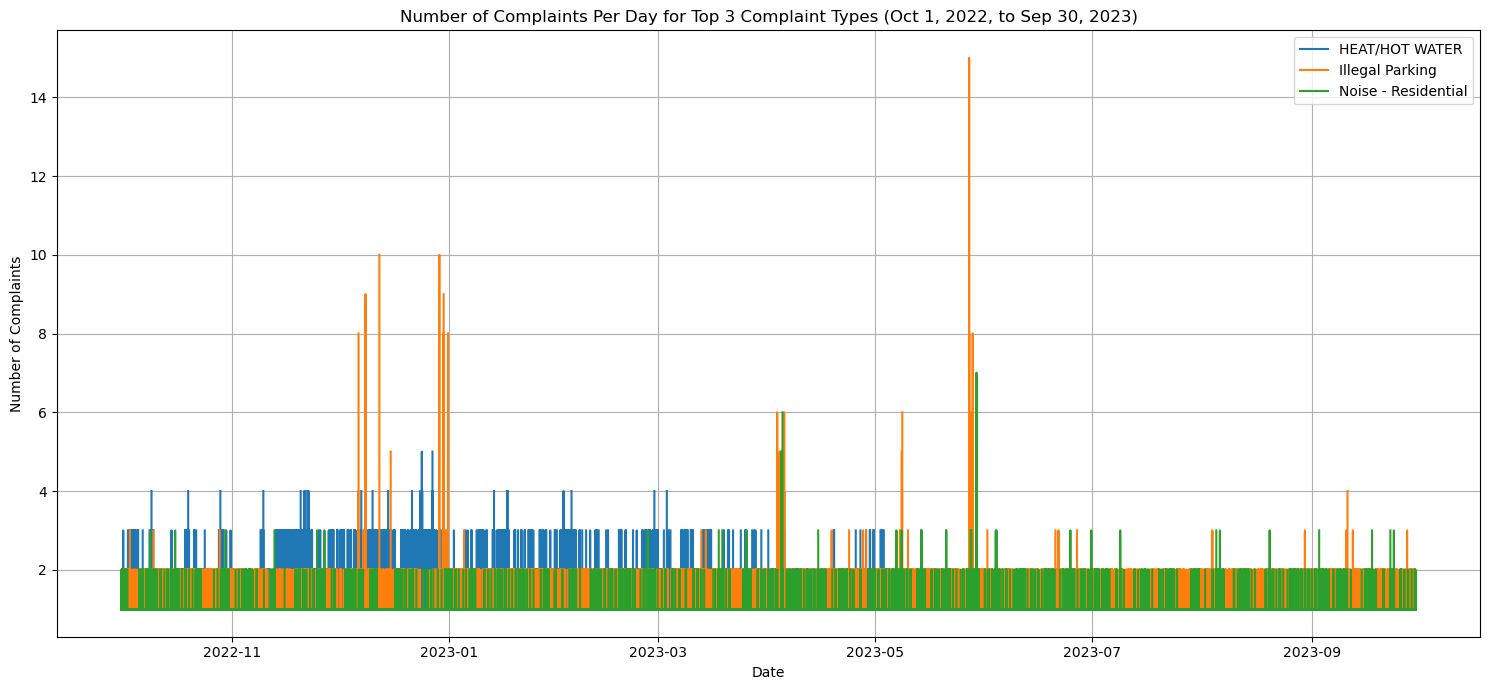

In [119]:
QUERY = """
SELECT created_date, complaint_type, COUNT(*) AS daily_complaint_count
FROM complaints
WHERE (complaint_type = 'Illegal Parking' OR 
       complaint_type = 'Noise - Residential' OR 
       complaint_type = 'HEAT/HOT WATER')
AND created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY created_date, complaint_type
ORDER BY created_date, complaint_type;
"""

with engine.connect() as conn:
    df = pd.read_sql(text(QUERY), conn)

pivot_df = df.pivot(index='created_date', columns='complaint_type', values='daily_complaint_count')

plt.figure(figsize=(15, 7))
for complaint_type in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[complaint_type], label=complaint_type)

plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Per Day for Top 3 Complaint Types (Oct 1, 2022, to Sep 30, 2023)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

### Visualization 2: What are the most common complaints in the immediate area?

While we may not all necessarily live in the vicinity of Columbia's campus, we certainly spend a lot of time here. Let's see what has been bothering residents in our neck of the woods. Clearly defining our zip code as "10027", we count all complaints received between October 1, 2018 and September 30, 2023, then place the top 10 categories in descending order. For greater transparency, we use a bar chart to highlight the differences in totals between each. Residential noise complaints exceed the rest by far, and for good reason. Those undergraduates really need to shut up!

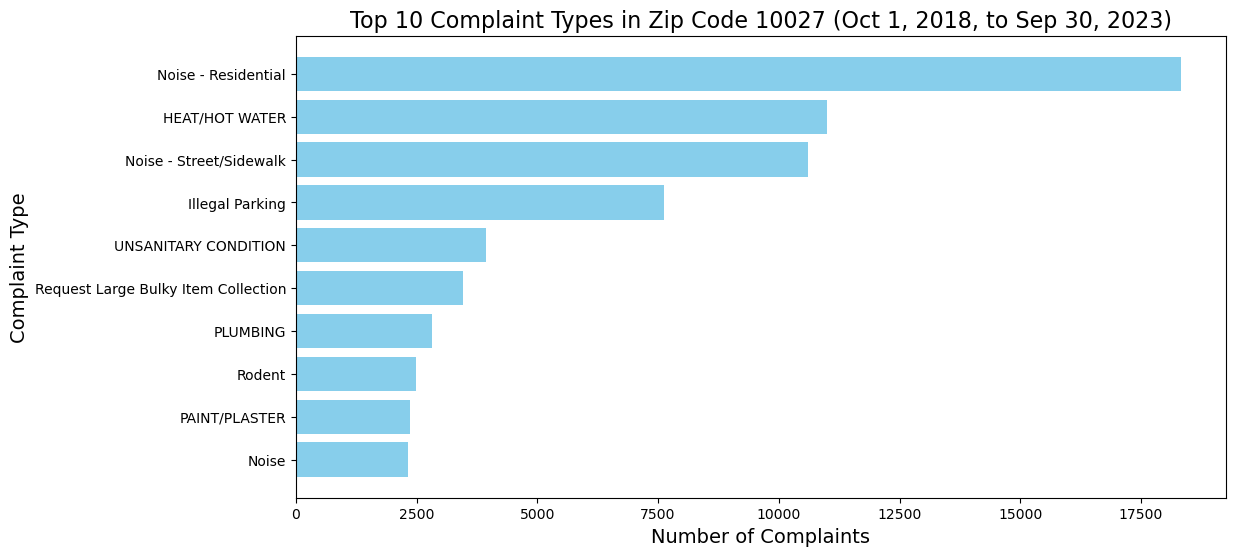

In [120]:
QUERY = """
SELECT complaint_type, COUNT(*) AS complaint_count
FROM complaints
WHERE zipcode = '10027'
AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
GROUP BY complaint_type
ORDER BY complaint_count DESC
LIMIT 10;
"""
with engine.connect() as conn:
    df = pd.read_sql(text(QUERY), conn)

# Plotting the results as a bar chart
plt.figure(figsize=(12, 6))
plt.barh(df['complaint_type'], df['complaint_count'], color='skyblue')
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Complaint Type', fontsize=14)
plt.title('Top 10 Complaint Types in Zip Code 10027 (Oct 1, 2018, to Sep 30, 2023)', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

### Visualization 3: Is there any correlation between rent, trees, and complaints at all?

Earlier on, we mentioned how the prevalence of greenery could be a socioeconomic dividing factor. Let's see if that's actually the case in New York City. After all, some of the wealthiest pockets of the city fall within the concrete jungles of Midtown and Lower Manhattan.

To evaluate our hypothesis, we query rent, tree count, and complaint count data by zip code. We then merge the data sets based on zip code, convert columns to numeric values, and create two scatter plots. One subplot displays rent compared to the number of trees by zip code, and the other shows rent compared to the number of complaints by zip code.

When it comes to trees, the majority appear in areas that are low-to-medium in rent. The areas with the highest rents are correspondingly lacking in greenery. This supports our thought process. Meanwhile, complaints appear to trend downwards as rents increase.

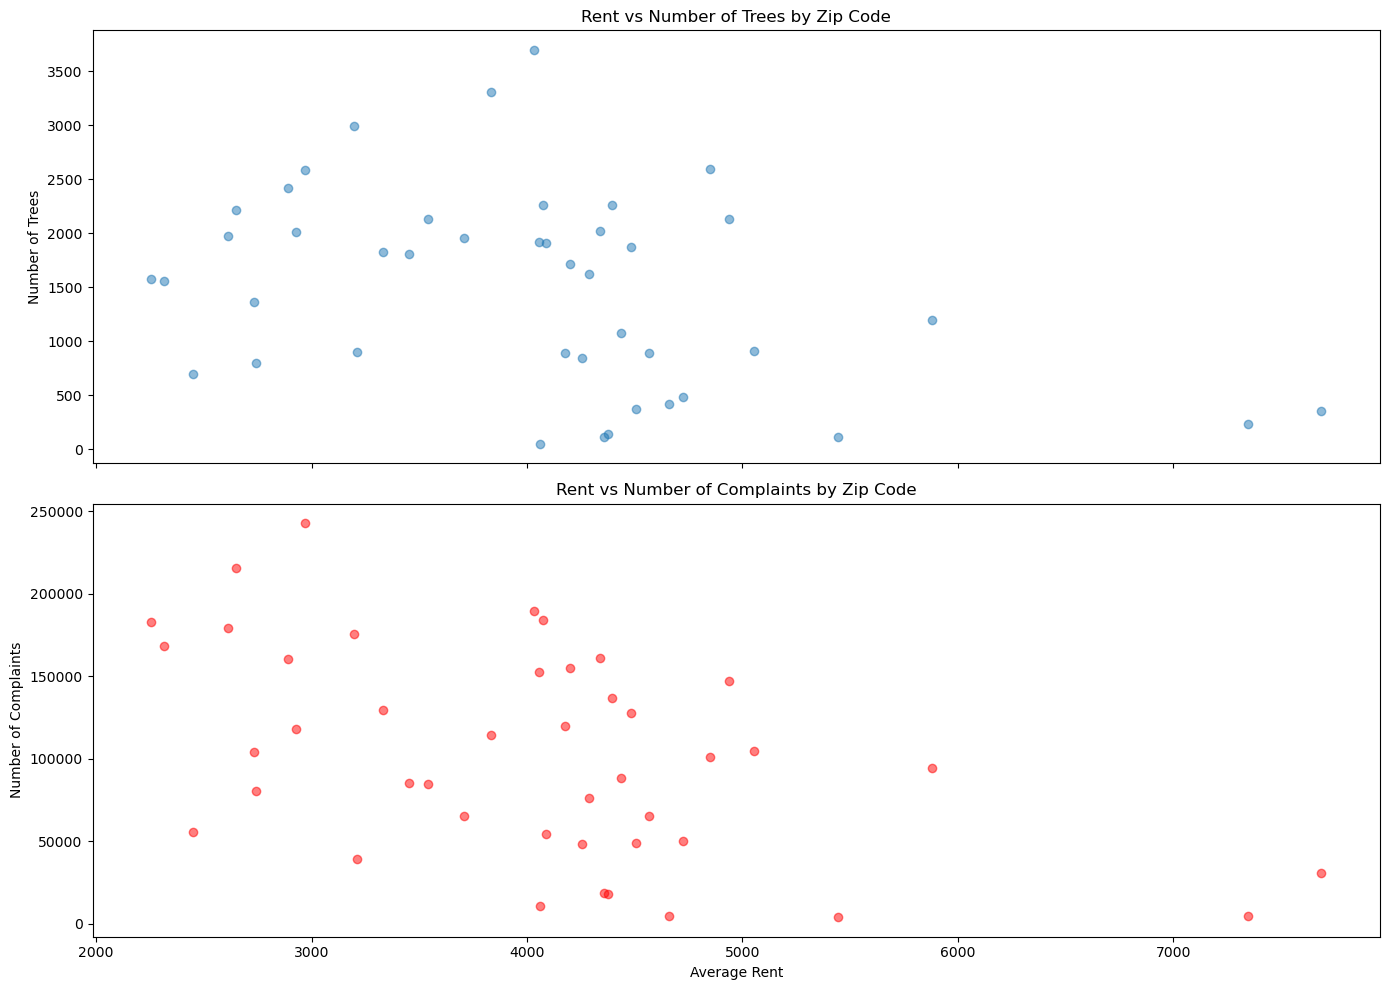

In [4]:
query_rent = """
SELECT zipcode, "2023-09-30" AS average_rent
FROM rents;
"""
df_rent = pd.read_sql(query_rent, engine)

# Query to get the tree count data by zip code
query_trees = """
SELECT zipcode, COUNT(*) AS tree_count
FROM trees
GROUP BY zipcode;
"""
df_trees = pd.read_sql(query_trees, engine)

# Query to get the complaints count data by zip code
query_complaints = """
SELECT zipcode, COUNT(*) AS complaint_count
FROM complaints
WHERE created_date BETWEEN '2015-01-01' AND '2023-09-30'
GROUP BY zipcode;
"""
df_complaints = pd.read_sql(query_complaints, engine)

# Merge the datasets on zipcode
df_merged = df_rent.merge(df_trees, on='zipcode', how='left').merge(df_complaints, on='zipcode', how='left')

# Convert columns to numeric and handle missing values
df_merged['average_rent'] = pd.to_numeric(df_merged['average_rent'], errors='coerce')
df_merged['tree_count'] = pd.to_numeric(df_merged['tree_count'], errors='coerce')
df_merged['complaint_count'] = pd.to_numeric(df_merged['complaint_count'], errors='coerce')
df_merged.dropna(inplace=True)

# Now create the visualizations
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Rent vs. Number of Trees
axs[0].scatter(df_merged['average_rent'], df_merged['tree_count'], alpha=0.5)
axs[0].set_ylabel('Number of Trees')
axs[0].set_title('Rent vs Number of Trees by Zip Code')

# Rent vs. Number of Complaints
axs[1].scatter(df_merged['average_rent'], df_merged['complaint_count'], alpha=0.5, color='red')
axs[1].set_xlabel('Average Rent')
axs[1].set_ylabel('Number of Complaints')
axs[1].set_title('Rent vs Number of Complaints by Zip Code')

# Show the plot
plt.tight_layout()
plt.show()

### Visualization 4: If I can afford more in rent, will there be fewer issues & complaints?

In the previous scatter plot, it appears as if areas with higher rents are associated with fewer complaints. Let's double-check if this is actually the case, by creating a box plot which references our prior query tying complaints to zip codes. We separate the rent data into bins of $1,000, grouping by the dollar amount of the rent bin and calculating summary statistics for the total count of complaints. With all of this executed, we create a box plot where the x-axis represents average rent in September 2023, while the y-axis highlights the number of 311 complaints observed in each zip code between October 1, 2022 and September 30, 2023. The average number of complaints appears to fluctuate in areas where rent falls in the low-to-medium range, but the minimum value definitely appears to decrease as rents increase.

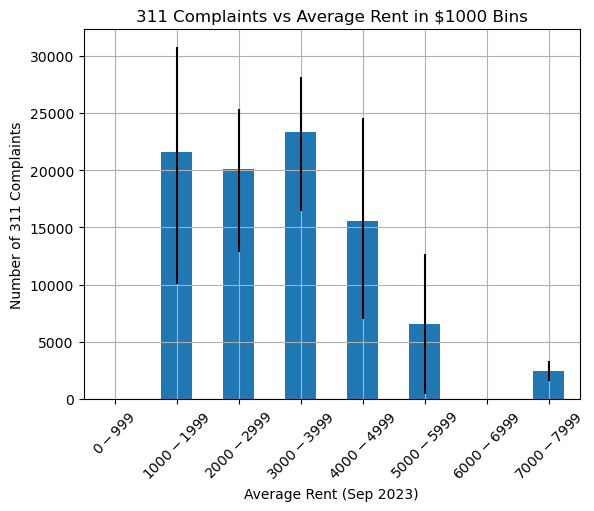

In [9]:
QUERY = """
SELECT 
    r.zipcode, 
    r."2023-09-30" AS September2023Rent,
    COUNT(c.complaint_type) AS ComplaintCount
FROM 
    rents r
LEFT JOIN 
    complaints c ON r.zipcode = c.zipcode
    AND c.created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY 
    r.zipcode, r."2023-09-30";
"""
with engine.connect() as conn:
    df = pd.read_sql(text(QUERY), conn)

df.dropna(subset=['september2023rent'], inplace=True)
# Bin the rent data into $1000 bins
bins = range(0, int(df['september2023rent'].max()) + 1000, 1000)
labels = [f"${i}-${i + 999}" for i in bins[:-1]]
df['RentBin'] = pd.cut(df['september2023rent'], bins=bins, labels=labels, right=False)
# Group by RentBin and calculate summary statistics for ComplaintCount
complaint_summary = df.groupby('RentBin')['complaintcount'].describe()

# Create boxplot
complaint_summary['mean'].plot(kind='bar', yerr=[complaint_summary['mean'] - complaint_summary['25%'], complaint_summary['75%'] - complaint_summary['mean']])
plt.xlabel('Average Rent (Sep 2023)')
plt.ylabel('Number of 311 Complaints')
plt.title('311 Complaints vs Average Rent in $1000 Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

v5

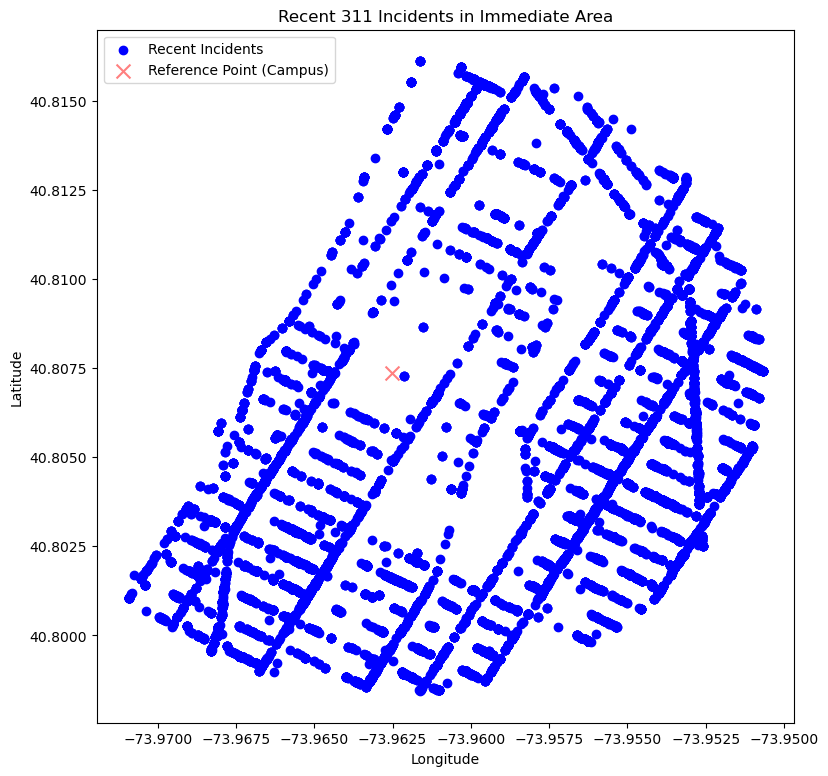

In [10]:
def plot_recent_311_incidents(dataframe5):
    plt.figure(figsize=(9, 9))
    plt.scatter(dataframe5['longitude'], dataframe5['latitude'], marker='o', color='blue', label="Recent Incidents")
    plt.scatter(-73.96253174434912, 40.80737875669467, marker='x', color='red', alpha=0.5, label='Reference Point (Campus)', s=100)
    plt.title("Recent 311 Incidents in Immediate Area")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc='upper left')
    plt.show()

def get_data_for_visual_5():
    V5 = """
    SELECT created_date, CAST(latitude AS NUMERIC), CAST(longitude AS NUMERIC)
    FROM complaints
    WHERE created_date BETWEEN '2023-01-01' AND '2023-09-30'
    AND ST_DistanceSphere(
        ST_MakePoint(CAST(longitude AS NUMERIC), CAST(latitude AS NUMERIC)),
        ST_MakePoint(-73.96253174434912, 40.80737875669467)
    ) <= 1000;
    """
    with engine.connect() as conn:
        result = conn.execute(text(V5))
        dataframe5 = pd.DataFrame(result.fetchall(), columns=result.keys())
        return dataframe5

# Execute the function and plot the data
some_dataframe5 = get_data_for_visual_5()
plot_recent_311_incidents(some_dataframe5)

v6

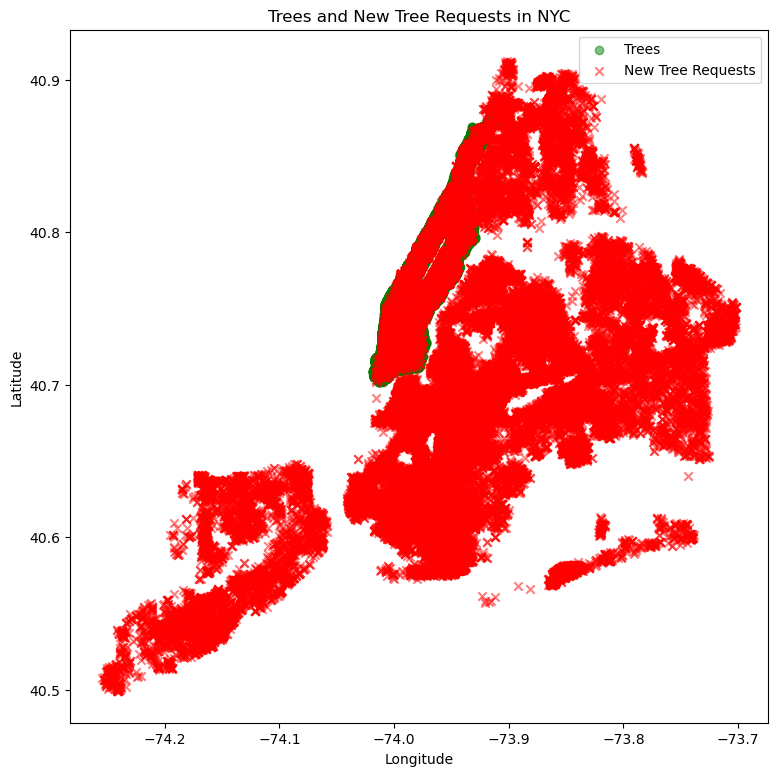

In [11]:
def plot_trees_and_complaints(tree_df, complaints_df):
    plt.figure(figsize=(9, 9))
    
    # Plot trees
    plt.scatter(tree_df['longitude'], tree_df['latitude'], marker='o', color='green', label='Trees', alpha=0.5)
    
    # Plot new tree requests
    plt.scatter(complaints_df['longitude'], complaints_df['latitude'], marker='x', color='red', label='New Tree Requests', alpha=0.5)
    
    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Trees and New Tree Requests in NYC")
    plt.show()

def get_data_for_visual_6():
    trees_query = """
    SELECT tree_id, ST_X(the_geom::geometry) AS longitude, ST_Y(the_geom::geometry) AS latitude
    FROM trees;
    """
    
    complaints_query = """
    SELECT created_date, CAST(latitude AS NUMERIC) AS latitude, CAST(longitude AS NUMERIC) AS longitude
    FROM complaints
    WHERE created_date BETWEEN '2018-10-01' AND '2023-09-30'
    AND complaint_type = 'New Tree Request';
    """
    
    with engine.connect() as conn:
        trees_df = gpd.GeoDataFrame(pd.read_sql(trees_query, conn))
        complaints_df = gpd.GeoDataFrame(pd.read_sql(complaints_query, conn))
    
    return trees_df, complaints_df

# Use the functions
trees_df, complaints_df = get_data_for_visual_6()
plot_trees_and_complaints(trees_df, complaints_df)